In [1]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split

In [2]:
#import os
#os.chdir("./../.")
#os.getcwd()

In [3]:
torch.autograd.set_detect_anomaly(True)

### Filtering the output 2

In [4]:
torch.__version__
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [5]:
with open("data/surrogate_model/animation_label.pkl", "rb") as f:
    surrogate2 = pickle.load(f)

#Filter with only good or very good ratings
#filtered_output = surrogate[surrogate)][['label'].isin(['Good','Very Good']["file","animation_id","model_output","label"]]
filtered_output2 = surrogate2[["file","animation_id","model_output","label"]]

# dictionary for mapping

mapping_dict = {"Very Good": 6, "Good": 5, "Bad": 4,"Okay":3, "Very Bad": 2, "no_rating": 1}

# Create another column changing the label into ints

filtered_output2['label2'] = filtered_output2['label'].replace(mapping_dict)


# get the names of unique logos by splitting with animation number
logos = filtered_output2["file"].str.split("_animation").str[0].unique()

#print(logos)

# create a data frame for the collected best animations
bestoutput2 = pd.DataFrame()

# go through each logo to find the best animation
for logo in logos:

    # make a data frame that contains all the animations of one logo
    temp = filtered_output2[filtered_output2["file"].str.contains(logo)]

    #display(temp)

    # create a sum 
    mean_by_label = temp.groupby('file')['label2'].mean().reset_index()

    #print(mean_by_label)

    bestlogo = mean_by_label.loc[mean_by_label['label2'].idxmax()]

    #print(bestlogo)

    # get all the animated paths with the best animation of the logo
    best_animations2 = temp[temp["file"]==bestlogo["file"]]

    # add to the file
    bestoutput2 = pd.concat([bestoutput2,best_animations2],axis=0, ignore_index=True)
bestoutput2 = bestoutput2.sort_values(by=['file','animation_id'])
display(bestoutput2)

filenames = bestoutput2["file"].unique()
list = []
for name in filenames:
    seq = bestoutput2[bestoutput2["file"]==name]
    seq = seq["model_output"]
    seq = pd.DataFrame(bestoutput2["model_output"].to_list(), columns=["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12"])
    
    seq = pd.concat([pd.DataFrame(0, index=seq.index, columns=range(0, 256)), seq], axis=1, ignore_index=True)
    
    if len(seq) > 4:
        seq = seq[:4]

    sos = pd.DataFrame([[30]*268])
    
    eos = pd.DataFrame([[50]*268])

    seq = pd.concat([sos, seq, eos], ignore_index=True)
    
    while len(seq) < 6:
           seq = pd.concat([seq, pd.DataFrame([[-100]*268])], ignore_index=True)
           
    #seq = seq.apply(lambda x: np.array(x).astype(np.float32))
    #tokens = []
    #for l in seq:
    #    tokens.append(torch.tensor(l))

    list.append(torch.tensor(seq.values))
outTensor2 = torch.stack(list)

outTensor2 = outTensor2.to(device)
print(outTensor2.max())
print(outTensor2.shape)
print(outTensor2)

C:\Users\okan2\AppData\Local\Temp\ipykernel_10012\1844141353.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_output2['label2'] = filtered_output2['label'].replace(mapping_dict)


,file,animation_id,model_output,label,label2
436,logo_0_animation_0,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Good,5.0
439,logo_0_animation_0,1,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
438,logo_0_animation_0,3,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
437,logo_0_animation_0,4,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.4205715...",Good,5.0
435,logo_0_animation_0,5,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0
...,...,...,...,...,...
892,logo_99_animation_0,21,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.4...",Very Good,6.0
811,logo_99_animation_0,22,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Very Good,6.0
891,logo_99_animation_0,22,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Very Good,6.0
810,logo_99_animation_0,23,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Very Good,6.0


tensor(50., dtype=torch.float64)
torch.Size([359, 6, 268])
tensor([[[30.0000, 30.0000, 30.0000,  ..., 30.0000, 30.0000, 30.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000,  0.8444,  0.7580],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.4206, -1.0000, -1.0000],
         [50.0000, 50.0000, 50.0000,  ..., 50.0000, 50.0000, 50.0000]],

        [[30.0000, 30.0000, 30.0000,  ..., 30.0000, 30.0000, 30.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000,  0.8444,  0.7580],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.4206, -1.0000, -1.0000],
         [50.0000, 50.0000, 50.0000,  ..., 50.0000, 50.0000, 50.0000]],

        [[30.0000, 30.0000, 30.0000,  ..., 30.0000, 30.0000, 30.0000],
         [ 0.0

### Creating the input tensor with the diltered output

In [6]:
with open("data\embeddings\path_embedding.pkl", "rb") as f:
    inp = pickle.load(f)

bestoutput2["filename"] = bestoutput2["file"].str.split("_animation").str[0]

display(bestoutput2)

inp['animation_id'] = inp['animation_id'].astype(int)

#names = bestoutput2["file"].str.replace("_animation_0", "")

#input = inp[(inp["filename"].isin(bestoutput2["filename"])) & (inp["animation_id"].isin(bestoutput2["animation_id"]))]
input = pd.merge(bestoutput2, inp, on=['filename', 'animation_id'], how='inner')
input = input.drop(['model_output', 'label', 'label2', 'file'], axis=1)

input = input.sort_values(by=['filename','animation_id'])
display(input)
filenames = input["filename"].unique()
#print(filenames)
list = []
for name in filenames:
    #print(name)
    seq = input[input["filename"]==name].loc[:, ~inp.columns.isin(["filename","animation_id"])][:4]
    #print(seq)
    seq = pd.concat([seq, pd.DataFrame(0, index=seq.index, columns=range(256, 268))], axis=1, ignore_index=True)

    while len(seq) < 4:
        seq = pd.concat([seq, pd.DataFrame([[-100]*268])], ignore_index=True)

    sos = pd.DataFrame([[30]*268])
    
    eos = pd.DataFrame([[50]*268])

    seq = pd.concat([sos, seq, eos], ignore_index=True)

    list.append(torch.tensor(seq.values))
    #print(list)
inpTensor2 = torch.stack(list)
inpTensor2 = inpTensor2.to(device)
print(inpTensor2)
print(inpTensor2.shape)

,file,animation_id,model_output,label,label2,filename
436,logo_0_animation_0,0,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Good,5.0,logo_0
439,logo_0_animation_0,1,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0,logo_0
438,logo_0_animation_0,3,"[0, 0, 0, 0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0,logo_0
437,logo_0_animation_0,4,"[0, 0, 1, 0, 0, 0, -1.0, -1.0, -1.0, 0.4205715...",Good,5.0,logo_0
435,logo_0_animation_0,5,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Good,5.0,logo_0
...,...,...,...,...,...,...
892,logo_99_animation_0,21,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.4...",Very Good,6.0,logo_99
811,logo_99_animation_0,22,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Very Good,6.0,logo_99
891,logo_99_animation_0,22,"[0, 0, 0, 1, 0, 0, -1.0, -1.0, -1.0, -1.0, 0.8...",Very Good,6.0,logo_99
810,logo_99_animation_0,23,"[0, 0, 0, 0, 1, 0, -1.0, -1.0, -1.0, -1.0, -1....",Very Good,6.0,logo_99


,animation_id,filename,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,0,logo_0,0.763518,-0.982797,-0.446681,1.089468,-0.070563,0.710206,-0.491675,-1.631172,...,0.339061,0.022934,0.195161,-0.046488,-0.492103,-0.605836,-1.282879,0.613195,0.297194,-0.172312
1,1,logo_0,0.851117,-1.775123,0.649689,-0.688600,0.216071,0.135211,-1.748761,-1.347670,...,-1.616431,-1.572003,0.242460,0.430259,0.079752,-1.039526,-0.696104,0.090277,-0.228757,0.144372
2,3,logo_0,0.291136,-0.928242,0.265542,-0.261439,-0.386160,1.256256,-0.414706,-1.206105,...,-0.446020,-1.369758,0.356421,1.456656,0.468766,-1.077724,-0.548627,-0.300660,0.632805,-0.136473
3,4,logo_0,0.504446,-0.543099,0.915062,1.293575,-0.849605,1.120387,-0.637641,-1.337280,...,0.162753,0.206993,-0.201259,-1.087391,-0.597388,-0.992079,-0.851486,-0.225463,-0.549269,0.088637
4,5,logo_0,-0.641569,-0.657125,-0.105109,-0.031630,-0.572032,0.912017,-0.569627,-1.573482,...,-1.079276,0.285482,1.532865,-0.375210,-0.249130,-0.551393,-1.024246,0.623726,-1.073305,0.166613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,21,logo_99,0.729620,-1.035586,0.390709,1.910684,-0.489203,2.197111,0.424709,-0.389426,...,1.130544,-1.892641,-0.690288,1.371062,0.718980,-0.827454,-0.557172,0.235162,0.523978,-0.592003
903,22,logo_99,1.147938,-0.799806,0.664411,1.610482,-0.612273,1.194499,0.076532,-0.662109,...,0.415811,-1.569571,-0.424470,0.518902,0.160598,-1.283986,-0.463894,0.319661,0.785325,-0.294870
904,22,logo_99,1.147938,-0.799806,0.664411,1.610482,-0.612273,1.194499,0.076532,-0.662109,...,0.415811,-1.569571,-0.424470,0.518902,0.160598,-1.283986,-0.463894,0.319661,0.785325,-0.294870
905,23,logo_99,1.645128,-1.911424,0.806118,0.850210,0.554424,1.578238,-0.722733,-0.704658,...,0.883759,-2.000007,-0.517095,2.213172,0.733567,-0.577074,-0.710312,-0.591997,0.836300,-0.720247


tensor([[[  30.0000,   30.0000,   30.0000,  ...,   30.0000,   30.0000,
            30.0000],
         [   0.7635,   -0.9828,   -0.4467,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.8511,   -1.7751,    0.6497,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.2911,   -0.9282,    0.2655,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.5044,   -0.5431,    0.9151,  ...,    0.0000,    0.0000,
             0.0000],
         [  50.0000,   50.0000,   50.0000,  ...,   50.0000,   50.0000,
            50.0000]],

        [[  30.0000,   30.0000,   30.0000,  ...,   30.0000,   30.0000,
            30.0000],
         [   0.9591,    0.4688,    0.3871,  ...,    0.0000,    0.0000,
             0.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.000

In [7]:
test = inpTensor2[:1,:,:]
test = test.to(torch.float32)
test = test.to(device)
print(test, test.shape)

tensor([[[30.0000, 30.0000, 30.0000,  ..., 30.0000, 30.0000, 30.0000],
         [ 0.7635, -0.9828, -0.4467,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8511, -1.7751,  0.6497,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2911, -0.9282,  0.2655,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.5044, -0.5431,  0.9151,  ...,  0.0000,  0.0000,  0.0000],
         [50.0000, 50.0000, 50.0000,  ..., 50.0000, 50.0000, 50.0000]]]) torch.Size([1, 6, 268])


### Model

In [8]:
print(inpTensor2, inpTensor2.shape)

print(outTensor2, outTensor2.shape)

tensor([[[  30.0000,   30.0000,   30.0000,  ...,   30.0000,   30.0000,
            30.0000],
         [   0.7635,   -0.9828,   -0.4467,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.8511,   -1.7751,    0.6497,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.2911,   -0.9282,    0.2655,  ...,    0.0000,    0.0000,
             0.0000],
         [   0.5044,   -0.5431,    0.9151,  ...,    0.0000,    0.0000,
             0.0000],
         [  50.0000,   50.0000,   50.0000,  ...,   50.0000,   50.0000,
            50.0000]],

        [[  30.0000,   30.0000,   30.0000,  ...,   30.0000,   30.0000,
            30.0000],
         [   0.9591,    0.4688,    0.3871,  ...,    0.0000,    0.0000,
             0.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.000

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [10]:

class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None, batch_first=True):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        #src = self.embedding(src) * math.sqrt(self.dim_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        #print(src.shape, tgt.shape)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [11]:
model = Transformer(
    num_tokens=268, dim_model=268, num_heads=67, num_encoder_layers=4, num_decoder_layers=8, dropout_p=0.01
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [12]:

def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[0], batch[1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        #print(y.shape, y_input, y_input.shape, y_expected, y_expected.shape)
        
        # Get mask to mask out the next words
        sequence_length = y.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        #print(X.shape, y.shape)
        pred = model(X, y)

        # Permute pred to have batch size first again
        #pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [13]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[0], batch[1]
            X, y = torch.tensor(X, device=device), torch.tensor(y, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            #print("val ", X.shape, y.shape, X.dtype, y.dtype)
            pred = model(X, y)

            # Permute pred to have batch size first again
            #pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [14]:
train_dataloader = DataLoader(TensorDataset(inpTensor2.float(), outTensor2.float()), batch_size=30, shuffle=True, drop_last=True)
val_dataloader = DataLoader(TensorDataset(inpTensor2.float(), outTensor2.float()),batch_size=30, shuffle=True,  drop_last=True)

def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 30)

Training and validating model
------------------------- Epoch 1 -------------------------


C:\Users\okan2\AppData\Local\Temp\ipykernel_10012\4031093003.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
C:\Users\okan2\AppData\Local\Temp\ipykernel_10012\735850417.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, device=device), torch.tensor(y, device=device)


Training loss: 533.0462
Validation loss: 498.2730

------------------------- Epoch 2 -------------------------
Training loss: 475.9472
Validation loss: 447.0410

------------------------- Epoch 3 -------------------------
Training loss: 431.4087
Validation loss: 411.1406

------------------------- Epoch 4 -------------------------
Training loss: 403.5338
Validation loss: 394.1416

------------------------- Epoch 5 -------------------------
Training loss: 392.3020
Validation loss: 389.7063

------------------------- Epoch 6 -------------------------
Training loss: 389.7791
Validation loss: 389.1811

------------------------- Epoch 7 -------------------------
Training loss: 389.3126
Validation loss: 389.1575

------------------------- Epoch 8 -------------------------
Training loss: 389.4195
Validation loss: 389.1290

------------------------- Epoch 9 -------------------------
Training loss: 389.0137
Validation loss: 388.8959

------------------------- Epoch 10 -------------------------


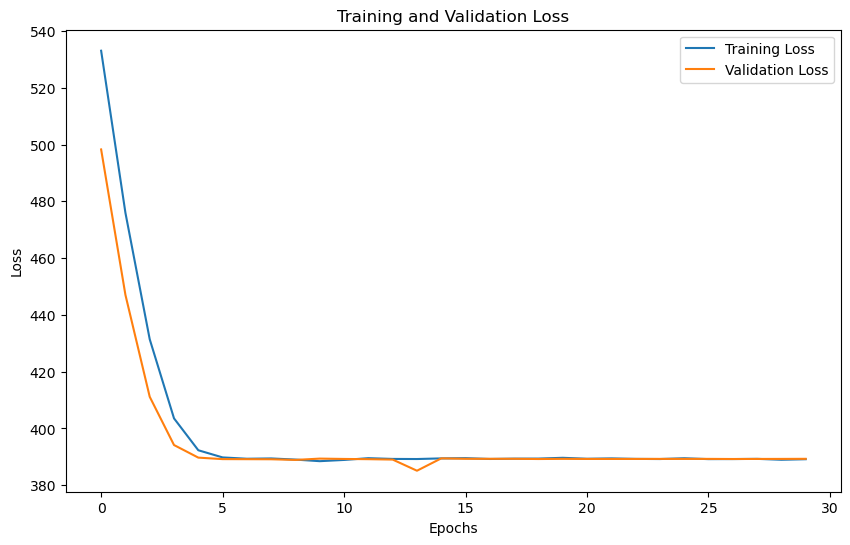

In [15]:
import matplotlib.pyplot as plt

# # Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
test.shape

In [ ]:
def predict(model, input_sequence, max_length=6, SOS_token=[[30] * 268], EOS_token=[[50] * 268]):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([SOS_token], dtype=torch.long, device=device)
    
    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1] # num with highest probability
        #next_item = torch.tensor([[next_item]], device=device)

        next_item = pred[:,:1,:]
        #print(next_item, next_item.shape)

        #print(input_sequence.shape, y_input.shape, next_item.shape, pred.shape)
        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item == EOS_token:
            break

    return y_input

In [ ]:
result = predict(model, test)

model_parameters = result[:,1:2,-12:].squeeze().tolist()
model_parameters = [value - math.floor(value) for value in model_parameters]
model_parameters = [round(value) if index < 6 else value for index, value in enumerate(model_parameters)]
print(model_parameters)

model_parameters = pd.DataFrame({"animation_id" : 2, "model_output" : [model_parameters]})

print(model_parameters, model_parameters.shape)


In [ ]:
result = predict(model, test)

model_parameters = result[:,1:,-12:].squeeze(0).detach().numpy()
print(model_parameters.shape)

model_parameters = pd.DataFrame(model_parameters)
model_parameters["model_output"] = model_parameters.apply(lambda row: row.tolist(), axis=1)

def process_model_output(lst):
    # Floor all values in the list
    lst = [value - math.floor(value) for value in lst]
    
    # Round the first 6 values in the list
    lst[:6] = [round(value) for value in lst[:6]]
    
    return lst

# Apply the custom function to the "model_output" column
model_parameters = model_parameters[['model_output']]
model_parameters['model_output'] = model_parameters['model_output'].apply(process_model_output)

model_parameters["animation_id"] = range(1, len(model_parameters)+1)
print(model_parameters, model_parameters.shape)

In [ ]:
from src.postprocessing.postprocessing import *

postprocess_logo(model_parameters, "data/1_inserted_animation_id/logo_0.svg")